In [1]:
import pandas as pd
import numpy as np

# GLIM Dataset Preparation

In [2]:
from pandas import DataFrame

# Prepare GLIM dataset
glim = pd.read_excel('GLIM/data.xlsx')


# optional Chair Stand Test (s), 
relevant_variables = ["6MWT results", "age ", "BMI (Body Mass Index)", "presence of cardiovascular disease", "presence of diabetes ", "FEV1", "Severity of COPD according to the GOLD classification", "FEV1/FVC EX", "gender", "height (cm)", "presence of hypertension ", "level of education", "number of regular drugs", "weight (kg)"]
# drop all non-relevant variables
glim = glim[relevant_variables]
# rename variables to something simpler
glim = glim.rename(columns={"age ":"AGE","6MWT results": "6MWT", "BMI (Body Mass Index)": "BMI", "presence of cardiovascular disease": "CVD","presence of diabetes ": "DIABETES","FEV1/FVC EX": "FEV1/FVC", "Severity of COPD according to the GOLD classification":"GOLD","gender":"GENDER","height (cm)":"HEIGHT","presence of hypertension ":"HYPERTENSION","level of education":"EDUCATION","weight (kg)": "WEIGHT", "number of regular drugs":"NUM_DRUGS"})

# if 6MWT column contains "unable to complete the 6MWT" set the record to 0, set variable to int
glim.loc[glim['6MWT'] == 'unable to complete the 6MWT', '6MWT'] = 0
glim['6MWT'] = glim['6MWT'].astype(int)

# "no" and "yes" are not numeric, so we need to convert them to 0 and 1
glim.loc[glim['CVD'] == 'no', 'CVD'] = 0
glim.loc[glim['CVD'] == 'yes', 'CVD'] = 1
glim['CVD'] = glim['CVD'].astype(int)
glim.loc[glim['DIABETES'] == 'no', 'DIABETES'] = 0
glim.loc[glim['DIABETES'] == 'yes', 'DIABETES'] = 1
glim['DIABETES'] = glim['DIABETES'].astype(int)

# convert GOLD variable: 'mild obstruction' > 0, 'moderate obstruction' > 1, 'severe obstruction' > 2, 'very severe obstruction' > 3
glim.loc[glim['GOLD'] == 'mild obstruction', 'GOLD'] = 0
glim.loc[glim['GOLD'] == 'moderate obstruction', 'GOLD'] = 1
glim.loc[glim['GOLD'] == 'severe obstruction', 'GOLD'] = 2
glim.loc[glim['GOLD'] == 'very severe obstruction', 'GOLD'] = 3
glim['GOLD'] = glim['GOLD'].astype(int)

# convert GENDER variable 'W' to 0, 'M' to 1
glim.loc[glim['GENDER'] == 'W', 'GENDER'] = 0
glim.loc[glim['GENDER'] == 'M', 'GENDER'] = 1
glim['GENDER'] = glim['GENDER'].astype(int)

# convert HYPERTENSION variable 'no' to 0, 'yes' to 1
glim.loc[glim['HYPERTENSION'] == 'no', 'HYPERTENSION'] = 0
glim.loc[glim['HYPERTENSION'] == 'yes', 'HYPERTENSION'] = 1
glim['HYPERTENSION'] = glim['HYPERTENSION'].astype(int)

# convert EDUCATION variable: 'no education' to 0, 'primary' to 1, 'secondary' to 2, 'vocational' to 3, 'higher' to 4
glim.loc[glim['EDUCATION'] == 'no education', 'EDUCATION'] = 0
glim.loc[glim['EDUCATION'] == 'primary', 'EDUCATION'] = 1
glim.loc[glim['EDUCATION'] == 'secondary', 'EDUCATION'] = 2
glim.loc[glim['EDUCATION'] == 'vocational', 'EDUCATION'] = 3
glim.loc[glim['EDUCATION'] == 'higher', 'EDUCATION'] = 4
glim['EDUCATION'] = glim['EDUCATION'].astype(int)

# TODO think about how to integrate number of chronic diseases

# set target variable (rename 'GOLD' to 'TARGET')
glim = glim.rename(columns={"GOLD":"TARGET"})

# replace outliers with median value for numeric variables
numeric_vars = ['6MWT', 'AGE', 'BMI', 'FEV1', 'FEV1/FVC', 'HEIGHT', 'WEIGHT', 'NUM_DRUGS']

OUTLIER_PARAM: int = 2 # define the number of stdev to use or the IQR scale (usually 1.5)
OPTION = 'iqr'  # or 'stdev'

def determine_outlier_thresholds(summary5: DataFrame, var: str):
    if 'iqr' == OPTION:
        iqr = OUTLIER_PARAM * (summary5[var]['75%'] - summary5[var]['25%'])
        top_threshold = summary5[var]['75%']  + iqr
        bottom_threshold = summary5[var]['25%']  - iqr
    else:  # OPTION == 'stdev'
        std = OUTLIER_PARAM * summary5[var]['std']
        top_threshold = summary5[var]['mean'] + std
        bottom_threshold = summary5[var]['mean'] - std
    return top_threshold, bottom_threshold

summary5 = glim.describe(include='number')
for var in numeric_vars:
    top_threshold, bottom_threshold = determine_outlier_thresholds(summary5, var)
    median = glim[var].median()
    glim[var] = glim[var].apply(lambda x: median if x > top_threshold or x < bottom_threshold else x)


# min max scaling of all variables except target variable
X = glim.drop(columns=['TARGET'])
X = (X - X.min()) / (X.max() - X.min())
X['TARGET'] = glim['TARGET']
glim = X

# drop EDUCATION for now
glim = glim.drop(columns=['EDUCATION'])

# if target is 1 set it to 0 if it is larger than 1 set it to 1
glim.loc[glim['TARGET'] == 1, 'TARGET'] = 0
glim.loc[glim['TARGET'] > 1, 'TARGET'] = 1

# balance using smote
print(glim['TARGET'].value_counts())
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X = glim.drop(columns=['TARGET'])
y = glim['TARGET']
X, y = smote.fit_resample(X, y)
glim = pd.concat([X, y], axis=1)
print(glim['TARGET'].value_counts())


# save to csv
# reset index and sort columns
glim = glim.reset_index(drop=True)
glim = glim.reindex(sorted(glim.columns), axis=1)
glim.to_csv('GLIM/glim_harvard.csv', index=False, sep=";")


1    64
0    60
Name: TARGET, dtype: int64
1    64
0    64
Name: TARGET, dtype: int64


# Harvard Dataset Preparation

In [4]:
harvard = pd.read_csv('harvard/dropped_variables.csv', sep=";")

# bclinra14 (6MWT), dem02 (age), bclinra01 (height), bclinra02 (weight), bclinpt06 (blockage of arteries), bclinpt07 (heart failure or congestive heart failure), bclinpt08 (heart attack, myocardial infarct), bclinpt09 (stroke or transient ischemic attack), bclinpt15 (diabetes), bclinra101 (FEV1), bclinra205 (FEV1/FVC), dem03 (gender), bclinra11 (GOLD), bclinpt04 (hypertension), Socio07 (education), bclinpt03 (chronic disease besides COPD))

# fclinra01	fclinra01_8192	fclinra01_4096	fclinra01_2048	fclinra01_1024	fclinra01_512	fclinra01_256	fclinra01_128	fclinra01_64	fclinra01_32	fclinra01_16	fclinra01_8	fclinra01_4	fclinra01_2	fclinra01_1


relevant_variables = ['bclinra14', 'dem02', 'bclinra01', 'bclinra02', 'bclinpt06', 'bclinpt07', 'bclinpt08', 'bclinpt09', 'bclinpt15', 'bclinra101', 'bclinra205', 'dem03', 'bclinra11', 'bclinpt04', 'Socio07', 'bclinpt03', 'fclinra01_8192', 'fclinra01_4096', 'fclinra01_2048', 'fclinra01_1024', 'fclinra01_512', 'fclinra01_256', 'fclinra01_128', 'fclinra01_64', 'fclinra01_32', 'fclinra01_16', 'fclinra01_8', 'fclinra01_4', 'fclinra01_2', 'fclinra01_1', 'bclinpt24']
harvard = harvard[relevant_variables]

# bclinra14 (6MWT), dem02 (age), bclinra01 (height), bclinra02 (weight), bclinpt06 (blockage of arteries), bclinpt07 (heart failure or congestive heart failure), bclinpt08 (heart attack, myocardial infarct), bclinpt09 (stroke or transient ischemic attack), bclinpt15 (diabetes), bclinra101 (FEV1), bclinra205 (FEV1/FVC), dem03 (gender), bclinra11 (GOLD), bclinpt04 (hypertension), Socio07 (education), bclinpt03 (chronic disease besides COPD))
harvard = harvard.rename(columns={'bclinra14':"6MWT", "dem02": "AGE", "bclinra01":"HEIGHT","bclinra02":"WEIGHT","bclinpt15":"DIABETES", "bclinra101":"FEV1", "bclinra205":"FEV1/FVC", "dem03":"GENDER", "bclinra11":"GOLD", "bclinpt04":"HYPERTENSION", "Socio07":"EDUCATION", "bclinpt03":"CHRONIC_DISEASE", 'bclinpt24': "TARGET"})

# TODO need to check if congestive heart failure and infarct should be part of cvd

# add CVD column
harvard['CVD'] = 0
# if bclinpt06 (blockage of arteries), bclinpt07 (heart failure or congestive heart failure), bclinpt08 (heart attack, myocardial infarct), bclinpt09 (stroke or transient ischemic attack) is true set CVD to 1
harvard.loc[(harvard['bclinpt06'] == 1) | (harvard['bclinpt07'] == 1) | (harvard['bclinpt08'] == 1) | (harvard['bclinpt09'] == 1), 'CVD'] = 1

# TODO
# transform education to GLIM standard (polish)

# TODO
# calculate number of chronic diseases

# calculate the number of drugs the patient is taking
# for every 1 in the drug labels add 1 to the number of drugs
harvard['NUM_DRUGS'] = 0
drug_labels = ['fclinra01_8192', 'fclinra01_4096', 'fclinra01_2048', 'fclinra01_1024', 'fclinra01_512', 'fclinra01_256', 'fclinra01_128', 'fclinra01_64', 'fclinra01_32', 'fclinra01_16', 'fclinra01_8', 'fclinra01_4', 'fclinra01_2', 'fclinra01_1']
for drug_label in drug_labels:
    harvard.loc[harvard[drug_label] == 1, 'NUM_DRUGS'] += 1

# drop bclinpt06	bclinpt07	bclinpt08	bclinpt09	fclinra01_1	fclinra01_1024	fclinra01_128	fclinra01_16	fclinra01_2	fclinra01_2048	fclinra01_256	fclinra01_32	fclinra01_4	fclinra01_4096	fclinra01_512	fclinra01_64	fclinra01_8	fclinra01_8192
harvard = harvard.drop(columns=['bclinpt06', 'bclinpt07', 'bclinpt08', 'bclinpt09', 'fclinra01_1', 'fclinra01_1024', 'fclinra01_128', 'fclinra01_16', 'fclinra01_2', 'fclinra01_2048', 'fclinra01_256', 'fclinra01_32', 'fclinra01_4', 'fclinra01_4096', 'fclinra01_512', 'fclinra01_64', 'fclinra01_8', 'fclinra01_8192'])

# missing value imputation
# numeric variables: 6MWT, AGE, HEIGHT, WEIGHT, FEV1, FEV1/FVC, NUM_DRUGS => use median
numeric_vars = ['6MWT', 'AGE', 'HEIGHT', 'WEIGHT', 'FEV1', 'FEV1/FVC', 'NUM_DRUGS']
for var in numeric_vars:
    harvard[var] = harvard[var].fillna(harvard[var].median())

# categorical variables: DIABETES, GENDER, GOLD, HYPERTENSION, EDUCATION, CHRONIC_DISEASE, CVD => use mode
categorical_vars = ['DIABETES', 'GENDER', 'GOLD', 'HYPERTENSION', 'EDUCATION', 'CHRONIC_DISEASE', 'CVD', 'TARGET']
for var in categorical_vars:
    harvard[var] = harvard[var].fillna(harvard[var].mode()[0])

# calculate bmi from height and weight
harvard['BMI'] = harvard['WEIGHT'] / ((harvard['HEIGHT'] / 100) ** 2)

## plot remaining missing values
# missing_values = harvard.isnull().sum()
# missing_values = missing_values[missing_values > 0]
# missing_values.sort_values(inplace=True)
# missing_values.plot.bar()

# handle outliers for numeric variables
OUTLIER_PARAM: int = 2 # define the number of stdev to use or the IQR scale (usually 1.5)
OPTION = 'stdev'  # or 'stdev'

def determine_outlier_thresholds(summary5: DataFrame, var: str):
    if 'iqr' == OPTION:
        iqr = OUTLIER_PARAM * (summary5[var]['75%'] - summary5[var]['25%'])
        top_threshold = summary5[var]['75%']  + iqr
        bottom_threshold = summary5[var]['25%']  - iqr
    else:  # OPTION == 'stdev'
        std = OUTLIER_PARAM * summary5[var]['std']
        top_threshold = summary5[var]['mean'] + std
        bottom_threshold = summary5[var]['mean'] - std
    return top_threshold, bottom_threshold

summary5 = harvard.describe(include='number')
for var in numeric_vars:
    top_threshold, bottom_threshold = determine_outlier_thresholds(summary5, var)
    median = harvard[var].median()
    harvard[var] = harvard[var].apply(lambda x: median if x > top_threshold or x < bottom_threshold else x)


# min max scaling of all variables except target variable
X = harvard.drop(columns=['TARGET'])
X = (X - X.min()) / (X.max() - X.min())
X['TARGET'] = harvard['TARGET']
harvard = X

# drop CHRONIC_DISEASE for now
harvard = harvard.drop(columns=['CHRONIC_DISEASE'])
# drop GOLD for now
harvard = harvard.drop(columns=['GOLD'])
# drop EDUCATION for now
harvard = harvard.drop(columns=['EDUCATION'])

# if target variable is 1 then set it to 0, otherwise 1
harvard.loc[harvard['TARGET'] == 1, 'TARGET'] = 0
# set all none 0 values to 1
harvard.loc[harvard['TARGET'] != 0, 'TARGET'] = 1

# balance using smote
print(harvard['TARGET'].value_counts())
sm = SMOTE(random_state=42)
X = harvard.drop(columns=['TARGET'])
y = harvard['TARGET']
X_res, y_res = sm.fit_resample(X, y)
harvard = pd.concat([X_res, y_res], axis=1)
print(harvard['TARGET'].value_counts())


# save to csv
# reset index and sort columns
harvard = harvard.reset_index(drop=True)
harvard = harvard.reindex(sorted(harvard.columns), axis=1)
harvard.to_csv('harvard/harvard_glim.csv', index=False, sep=";")

0.0    1686
1.0    1110
Name: TARGET, dtype: int64
0.0    1686
1.0    1686
Name: TARGET, dtype: int64


C:\Users\Daniel\AppData\Local\Temp\ipykernel_12352\2535514751.py:1: DtypeWarning: Columns (24,157,481,483,484,486,487,503) have mixed types. Specify dtype option on import or set low_memory=False.
  harvard = pd.read_csv('harvard/dropped_variables.csv', sep=";")


# Data Visualization

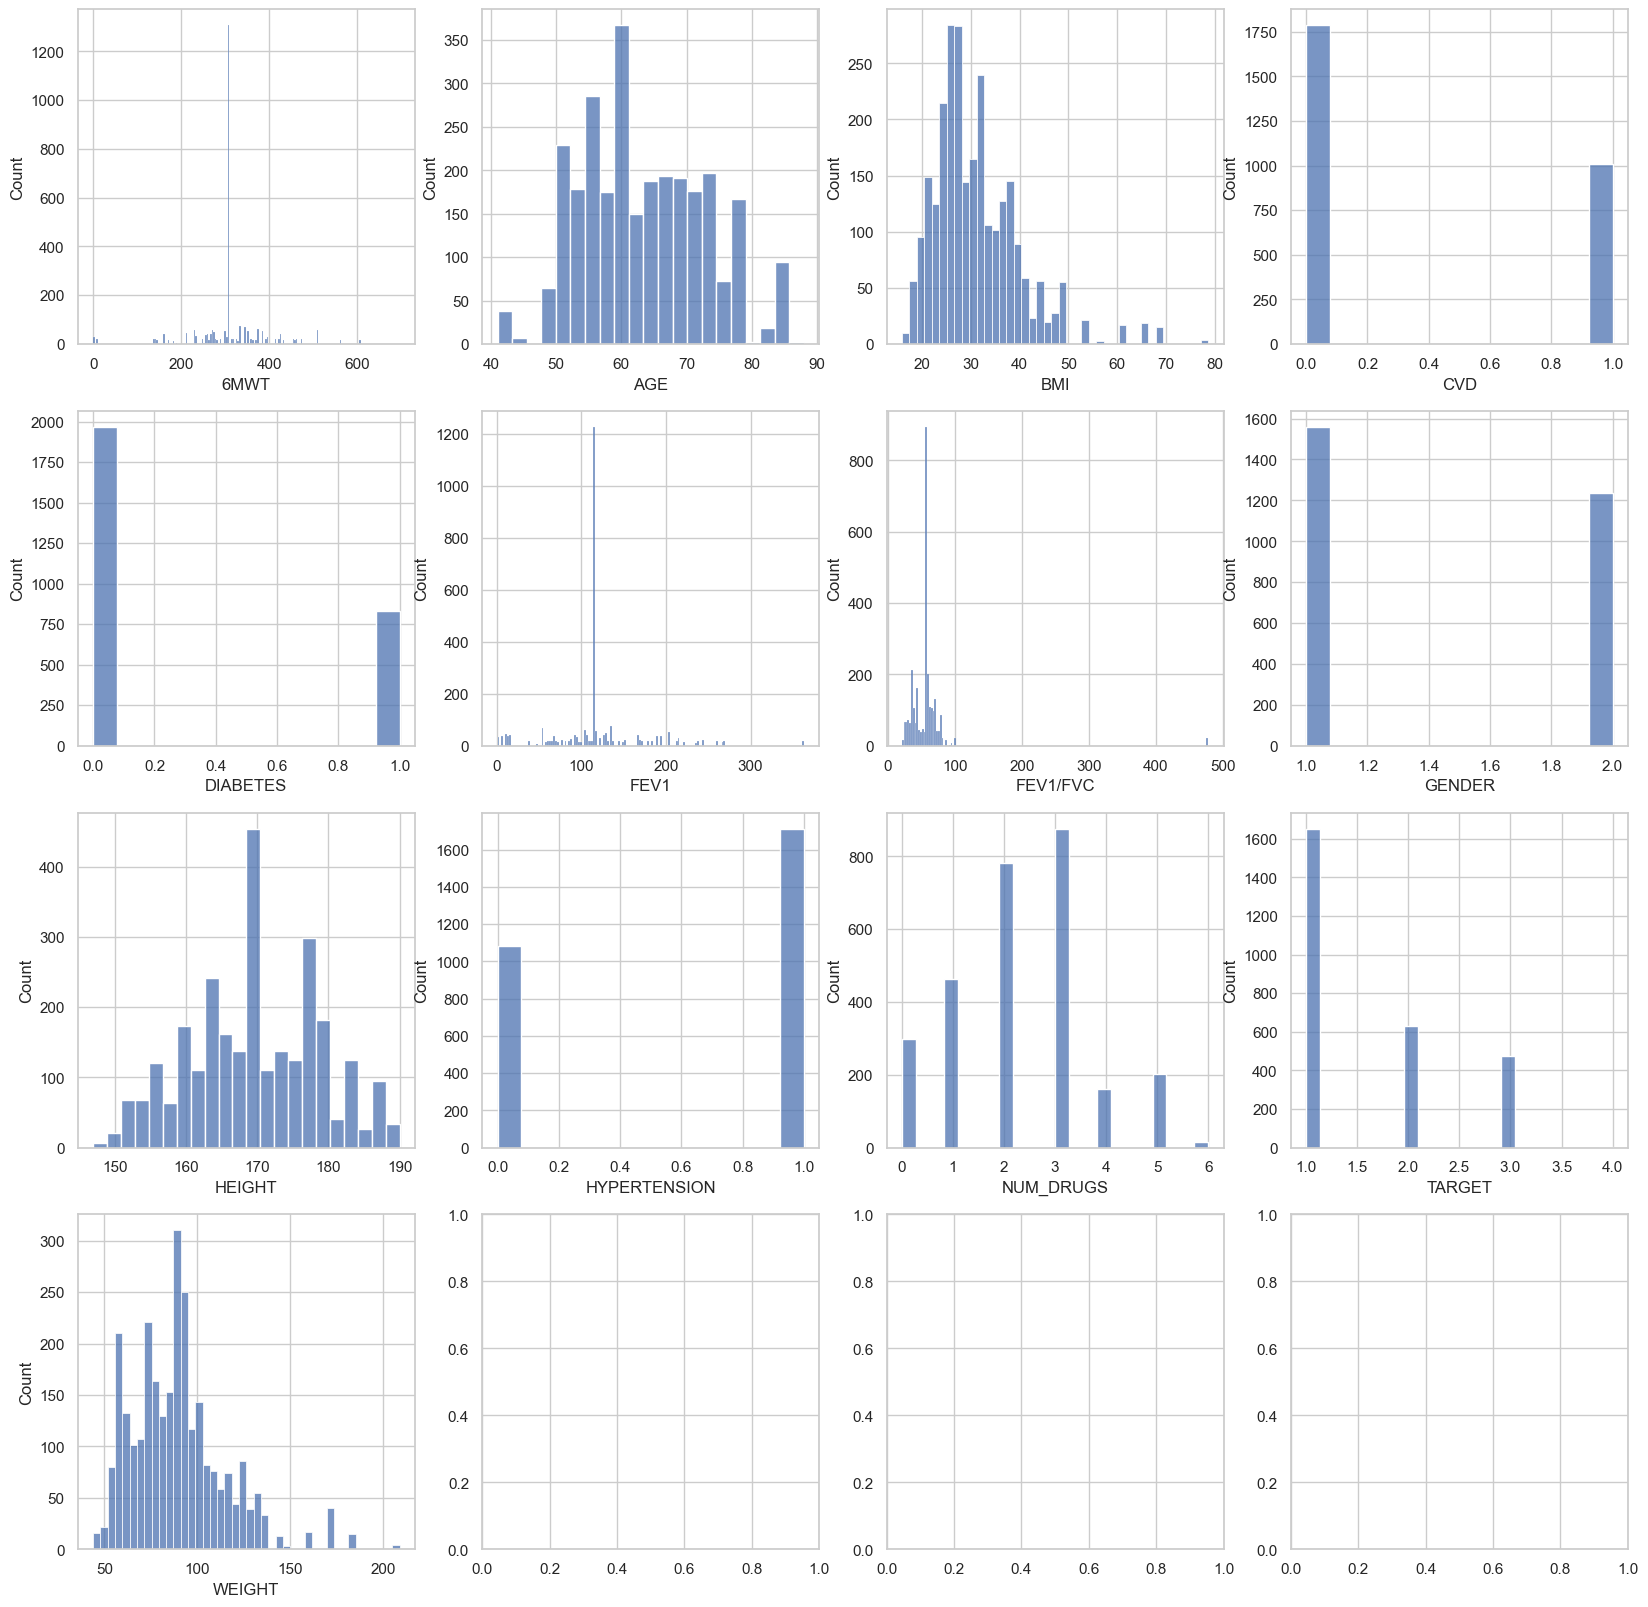

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot 13 histograms of each variable in one figure
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, var in enumerate(harvard.columns):
    sns.histplot(harvard[var], ax=axs[i // 4, i % 4])
    
plt.show()
    


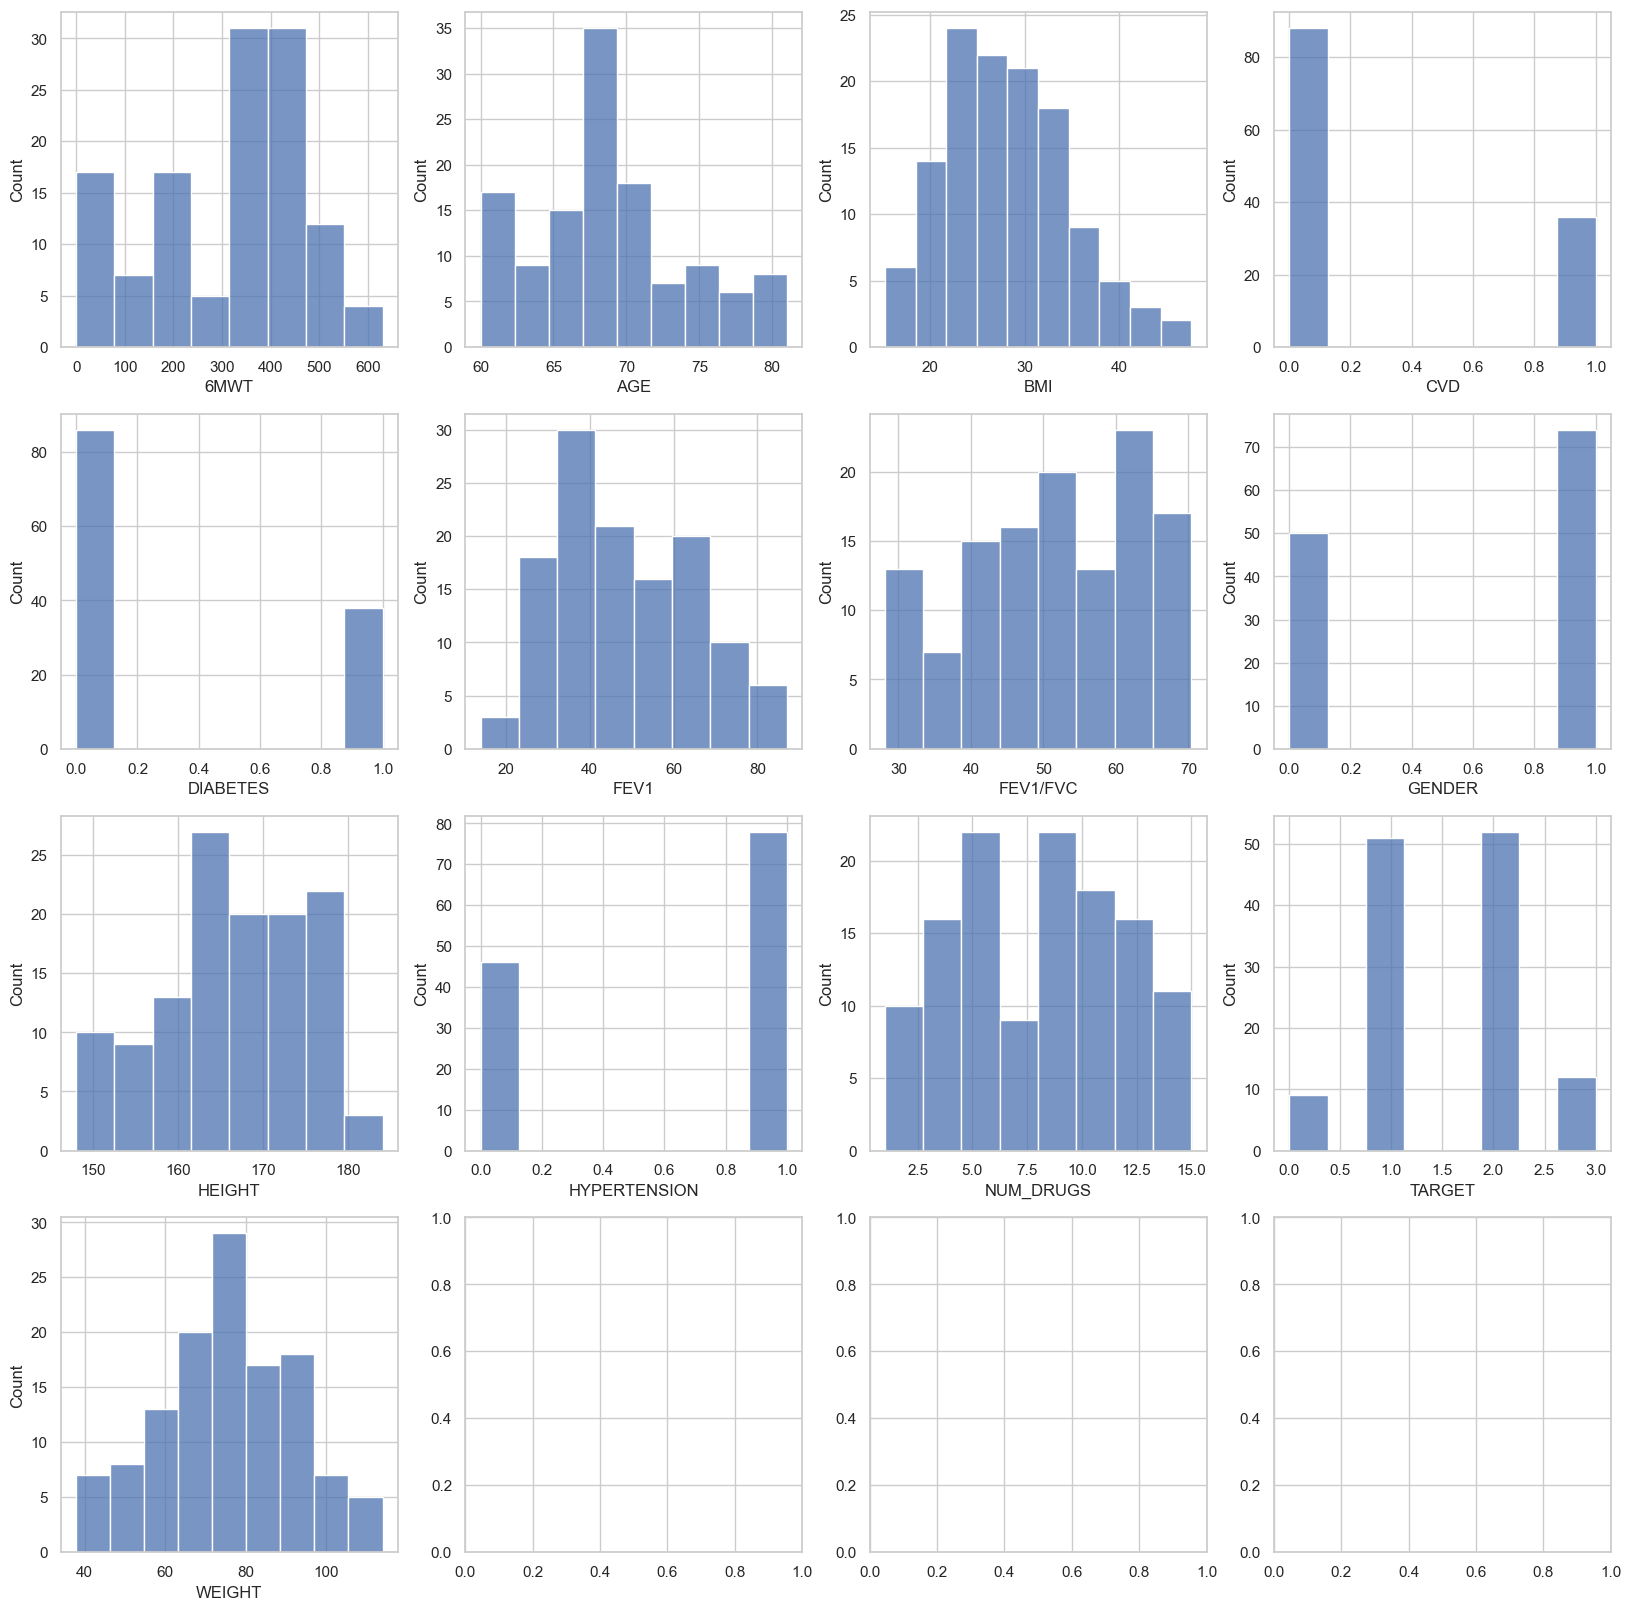

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot 13 histograms of each variable in one figure
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, var in enumerate(glim.columns):
    sns.histplot(glim[var], ax=axs[i // 4, i % 4])
    
plt.show()

# Intra dataset training

In [ ]:
# try out different classifiers using lazy predict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

X = glim.drop('GOLD', axis=1)
y = glim['GOLD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LazyClassifier()
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

[0.05821426 0.04588653 0.05382579 0.02557548 0.02985321 0.37341517
 0.15231912 0.02948248 0.04916687 0.02067669 0.03880642 0.06041351
 0.06236448]


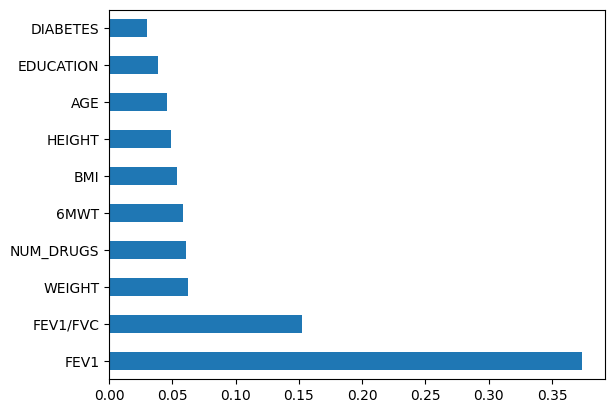

In [10]:
# determine most important variables
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# Inter dataset training

In [5]:
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# train on GLIM and test on HARVARD
X_train = glim.drop(columns=['TARGET'], axis=1)
y_train = glim['TARGET']

X_test = harvard.drop(columns=['TARGET'], axis=1)
y_test = harvard['TARGET']

clf = LazyClassifier(verbose=1)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

# clf = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# evaluate


# print('Accuracy: ', accuracy_score(y_test, y_pred))
# print('Precision: ', precision_score(y_test, y_pred))
# print('Recall: ', recall_score(y_test, y_pred))
# print('F1: ', f1_score(y_test, y_pred))
# print('Confusion matrix: ', confusion_matrix(y_test, y_pred))


 24%|██▍       | 7/29 [00:00<00:00, 68.61it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.4211150652431791, 'Balanced Accuracy': 0.4211150652431791, 'ROC AUC': 0.4211150652431791, 'F1 Score': 0.33749121807556587, 'Time taken': 0.015002965927124023}
{'Model': 'BaggingClassifier', 'Accuracy': 0.4211150652431791, 'Balanced Accuracy': 0.4211150652431791, 'ROC AUC': 0.4211150652431791, 'F1 Score': 0.33749121807556587, 'Time taken': 0.024006366729736328}
{'Model': 'BernoulliNB', 'Accuracy': 0.4211150652431791, 'Balanced Accuracy': 0.4211150652431791, 'ROC AUC': 0.4211150652431791, 'F1 Score': 0.35412111171164173, 'Time taken': 0.014002799987792969}
{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.43416370106761565, 'Balanced Accuracy': 0.43416370106761565, 'ROC AUC': 0.43416370106761565, 'F1 Score': 0.38196100973834346, 'Time taken': 0.02600574493408203}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.4211150652431791, 'Balanced Accuracy': 0.4211150652431791, 'ROC AUC': 0.4211150652431791, 'F1 Score': 0.33749121807556587, 'Time tak

 72%|███████▏  | 21/29 [00:00<00:00, 47.18it/s]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.5690984578884934, 'Balanced Accuracy': 0.5690984578884934, 'ROC AUC': 0.5690984578884934, 'F1 Score': 0.5545693291778729, 'Time taken': 0.0773916244506836}
{'Model': 'LabelPropagation', 'Accuracy': 0.5177935943060499, 'Balanced Accuracy': 0.5177935943060499, 'ROC AUC': 0.5177935943060499, 'F1 Score': 0.5136296864022482, 'Time taken': 0.019001007080078125}
{'Model': 'LabelSpreading', 'Accuracy': 0.5177935943060499, 'Balanced Accuracy': 0.5177935943060499, 'ROC AUC': 0.5177935943060499, 'F1 Score': 0.5136296864022482, 'Time taken': 0.02000904083251953}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.5913404507710558, 'Balanced Accuracy': 0.5913404507710558, 'ROC AUC': 0.5913404507710558, 'F1 Score': 0.5264778535964977, 'Time taken': 0.012002706527709961}
{'Model': 'LinearSVC', 'Accuracy': 0.42526690391459077, 'Balanced Accuracy': 0.4252669039145907, 'ROC AUC': 0.4252669039145907, 'F1 Score': 0.3568219468870468, 'Time taken': 0.0118525

100%|██████████| 29/29 [00:00<00:00, 41.92it/s]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.43030842230130484, 'Balanced Accuracy': 0.43030842230130484, 'ROC AUC': 0.4303084223013049, 'F1 Score': 0.3527886060791358, 'Time taken': 0.11188483238220215}
{'Model': 'RidgeClassifier', 'Accuracy': 0.6037959667852907, 'Balanced Accuracy': 0.6037959667852906, 'ROC AUC': 0.6037959667852906, 'F1 Score': 0.5836352175914202, 'Time taken': 0.013410329818725586}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.6233689205219455, 'Balanced Accuracy': 0.6233689205219455, 'ROC AUC': 0.6233689205219455, 'F1 Score': 0.6213536709712262, 'Time taken': 0.010521411895751953}
{'Model': 'SGDClassifier', 'Accuracy': 0.4792408066429419, 'Balanced Accuracy': 0.4792408066429419, 'ROC AUC': 0.4792408066429418, 'F1 Score': 0.46186018764811665, 'Time taken': 0.010675430297851562}
{'Model': 'SVC', 'Accuracy': 0.5877817319098458, 'Balanced Accuracy': 0.5877817319098457, 'ROC AUC': 0.5877817319098457, 'F1 Score': 0.5844928683278867, 'Time taken': 0.02500629425048828}

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RidgeClassifierCV,0.62,0.62,0.62,0.62,0.01
NuSVC,0.60,0.60,0.60,0.60,0.03
RidgeClassifier,0.60,0.60,0.60,0.58,0.01
NearestCentroid,0.60,0.60,0.60,0.58,0.01
LinearDiscriminantAnalysis,0.59,0.59,0.59,0.53,0.01
SVC,0.59,0.59,0.59,0.58,0.03
KNeighborsClassifier,0.57,0.57,0.57,0.55,0.08
LogisticRegression,0.53,0.53,0.53,0.52,0.02
ExtraTreeClassifier,0.52,0.52,0.52,0.51,0.01


In [6]:
# train on harvard and test on glim
X_train = harvard.drop(columns=['TARGET'], axis=1)
y_train = harvard['TARGET']

X_test = glim.drop(columns=['TARGET'], axis=1)
y_test = glim['TARGET']

clf = LazyClassifier(verbose=1)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

  3%|▎         | 1/29 [00:00<00:03,  7.31it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.53125, 'Balanced Accuracy': 0.53125, 'ROC AUC': 0.53125, 'F1 Score': 0.49566587864460204, 'Time taken': 0.13580107688903809}
{'Model': 'BaggingClassifier', 'Accuracy': 0.5390625, 'Balanced Accuracy': 0.5390625, 'ROC AUC': 0.5390625, 'F1 Score': 0.42504758279406174, 'Time taken': 0.04418540000915527}
{'Model': 'BernoulliNB', 'Accuracy': 0.4296875, 'Balanced Accuracy': 0.4296875, 'ROC AUC': 0.4296875, 'F1 Score': 0.3408112874779542, 'Time taken': 0.008856058120727539}


 14%|█▍        | 4/29 [00:00<00:03,  6.76it/s]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.671875, 'Balanced Accuracy': 0.671875, 'ROC AUC': 0.671875, 'F1 Score': 0.6652552926525529, 'Time taken': 0.39713430404663086}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.4765625, 'Balanced Accuracy': 0.4765625, 'ROC AUC': 0.4765625, 'F1 Score': 0.39499118165784836, 'Time taken': 0.011002540588378906}
{'Model': 'DummyClassifier', 'Accuracy': 0.5, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.3333333333333333, 'Time taken': 0.007915258407592773}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.5625, 'Balanced Accuracy': 0.5625, 'ROC AUC': 0.5625, 'F1 Score': 0.5333333333333333, 'Time taken': 0.010002851486206055}
{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.5, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.3708141321044547, 'Time taken': 0.15259933471679688}


 31%|███       | 9/29 [00:00<00:01, 13.33it/s]

{'Model': 'GaussianNB', 'Accuracy': 0.5, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.3816425120772947, 'Time taken': 0.009030580520629883}
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.5234375, 'Balanced Accuracy': 0.5234375, 'ROC AUC': 0.5234375, 'F1 Score': 0.5227092120545265, 'Time taken': 0.020575761795043945}


 41%|████▏     | 12/29 [00:01<00:01, 11.28it/s]

{'Model': 'LabelPropagation', 'Accuracy': 0.5234375, 'Balanced Accuracy': 0.5234375, 'ROC AUC': 0.5234375, 'F1 Score': 0.5227092120545265, 'Time taken': 0.3058626651763916}


 55%|█████▌    | 16/29 [00:01<00:01,  9.34it/s]

{'Model': 'LabelSpreading', 'Accuracy': 0.5234375, 'Balanced Accuracy': 0.5234375, 'ROC AUC': 0.5234375, 'F1 Score': 0.5227092120545265, 'Time taken': 0.41919374465942383}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.65625, 'Balanced Accuracy': 0.65625, 'ROC AUC': 0.65625, 'F1 Score': 0.6493150684931506, 'Time taken': 0.020844697952270508}
{'Model': 'LinearSVC', 'Accuracy': 0.65625, 'Balanced Accuracy': 0.65625, 'ROC AUC': 0.65625, 'F1 Score': 0.6493150684931506, 'Time taken': 0.11460280418395996}
{'Model': 'LogisticRegression', 'Accuracy': 0.6484375, 'Balanced Accuracy': 0.6484375, 'ROC AUC': 0.6484375, 'F1 Score': 0.6387129147588283, 'Time taken': 0.015062808990478516}
{'Model': 'NearestCentroid', 'Accuracy': 0.65625, 'Balanced Accuracy': 0.65625, 'ROC AUC': 0.65625, 'F1 Score': 0.6549019607843137, 'Time taken': 0.007996320724487305}


 62%|██████▏   | 18/29 [00:01<00:01,  8.90it/s]

{'Model': 'NuSVC', 'Accuracy': 0.5234375, 'Balanced Accuracy': 0.5234375, 'ROC AUC': 0.5234375, 'F1 Score': 0.44160766645212046, 'Time taken': 0.2435617446899414}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.609375, 'Balanced Accuracy': 0.609375, 'ROC AUC': 0.609375, 'F1 Score': 0.55703211517165, 'Time taken': 0.01082468032836914}
{'Model': 'Perceptron', 'Accuracy': 0.640625, 'Balanced Accuracy': 0.640625, 'ROC AUC': 0.640625, 'F1 Score': 0.6166666666666667, 'Time taken': 0.007826089859008789}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.5390625, 'Balanced Accuracy': 0.5390625, 'ROC AUC': 0.5390625, 'F1 Score': 0.49189261925587024, 'Time taken': 0.010514974594116211}


 90%|████████▉ | 26/29 [00:02<00:00, 15.13it/s]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.5, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.3708141321044547, 'Time taken': 0.1886451244354248}
{'Model': 'RidgeClassifier', 'Accuracy': 0.65625, 'Balanced Accuracy': 0.65625, 'ROC AUC': 0.65625, 'F1 Score': 0.6493150684931506, 'Time taken': 0.01100468635559082}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.65625, 'Balanced Accuracy': 0.65625, 'ROC AUC': 0.65625, 'F1 Score': 0.6493150684931506, 'Time taken': 0.01187896728515625}
{'Model': 'SGDClassifier', 'Accuracy': 0.65625, 'Balanced Accuracy': 0.65625, 'ROC AUC': 0.65625, 'F1 Score': 0.6362696977525187, 'Time taken': 0.018639087677001953}
{'Model': 'SVC', 'Accuracy': 0.5, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.4258480515839641, 'Time taken': 0.08995676040649414}
{'Model': 'XGBClassifier', 'Accuracy': 0.5078125, 'Balanced Accuracy': 0.5078125, 'ROC AUC': 0.5078125, 'F1 Score': 0.4059668508287293, 'Time taken': 0.06801462173461914}


100%|██████████| 29/29 [00:02<00:00, 11.91it/s]

{'Model': 'LGBMClassifier', 'Accuracy': 0.515625, 'Balanced Accuracy': 0.515625, 'ROC AUC': 0.515625, 'F1 Score': 0.42840679919331603, 'Time taken': 0.07501697540283203}


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
CalibratedClassifierCV,0.67,0.67,0.67,0.67,0.40
LinearSVC,0.66,0.66,0.66,0.65,0.11
SGDClassifier,0.66,0.66,0.66,0.64,0.02
RidgeClassifierCV,0.66,0.66,0.66,0.65,0.01
RidgeClassifier,0.66,0.66,0.66,0.65,0.01
NearestCentroid,0.66,0.66,0.66,0.65,0.01
LinearDiscriminantAnalysis,0.66,0.66,0.66,0.65,0.02
LogisticRegression,0.65,0.65,0.65,0.64,0.02
Perceptron,0.64,0.64,0.64,0.62,0.01
